In [2]:
# loading the Datasets
mortality = pd.read_parquet("../../Data/processed/mortality_corrected.parquet")
shipment = pd.read_parquet("../../Data/processed/shipment_eda.parquet")

In [3]:
mortality.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate
11216,Texas,TX,CAMERON,48061,2012,25,415729.0,0.000060
1099,California,CA,SONOMA,06097,2010,81,484675.0,0.000167
1696,Florida,FL,HILLSBOROUGH,12057,2009,288,1214050.0,0.000237
11703,Texas,TX,SAN PATRICIO,48409,2005,5,67232.0,0.000074
10481,South Carolina,SC,RICHLAND,45079,2015,35,406455.0,0.000086


In [4]:
shipment.sample(5)

,BUYER_STATE,BUYER_COUNTY,YEAR,MME
29870,OR,MULTNOMAH,2011,3.628501e+08
38333,VA,ALLEGHANY,2008,3.478238e+06
13116,KS,WILSON,2007,1.931878e+06
4830,FL,TAYLOR,2018,1.180879e+07
17904,MN,DOUGLAS,2017,7.826543e+06


In [5]:
# Creating control variables

# Enter the Test State Below
test_state = "WA"

# Enter list of states required below, Included the test state
state_list = ["WA", "OR", "WI", "NJ"]

# Year control variable
policy_year = 2012  # year the policy was implemented
start_year = 2008  # desired start year for analysis
end_year = 2015  # desired end year for analysis

In [6]:
# subset the data
mortality = mortality[mortality["State_Code"].isin(state_list)]
mortality = mortality[
    (mortality["Year"] >= start_year) & (mortality["Year"] <= end_year)
]

In [7]:
# check number of times each county appears in the data
mortality["County_Code"].value_counts().value_counts()

count
8    77
Name: count, dtype: int64

In [8]:
# Add columns to tag the rows for pre-post policy implementation and test-control

# Tagging the rows for pre-post policy implementation
mortality["policy_implementation"] = mortality["Year"] >= policy_year

# Tagging the rows for test-control
mortality["State_Type"] = mortality["State_Code"].apply(
    lambda x: "Test" if x == test_state else "Control"
)

In [9]:
mortality.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate,policy_implementation,State_Type
6577,New Jersey,NJ,CUMBERLAND,34011,2012,28,156862.0,0.000179,True,Control
6615,New Jersey,NJ,HUDSON,34017,2011,52,645658.0,0.000081,False,Control
6578,New Jersey,NJ,CUMBERLAND,34011,2013,25,155912.0,0.000160,True,Control
9452,Oregon,OR,LINCOLN,41041,2013,6,46351.0,0.000129,True,Control
13335,Wisconsin,WI,SHEBOYGAN,55117,2010,12,115520.0,0.000104,False,Control


In [10]:
mortality_2 = (
    mortality.groupby(["State_Code", "Year", "policy_implementation"])
    .agg({"Mortality_Rate": "mean"})
    .reset_index()
)

In [11]:
mortality_2.sample(5)

,State_Code,Year,policy_implementation,Mortality_Rate
12,OR,2012,True,0.000146
26,WI,2010,False,0.000120
19,WA,2011,False,0.000157
30,WI,2014,True,0.000160
27,WI,2011,False,0.000133


/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(-6.359374999999991, 0.5, 'Mortality Rate Per-Capita')

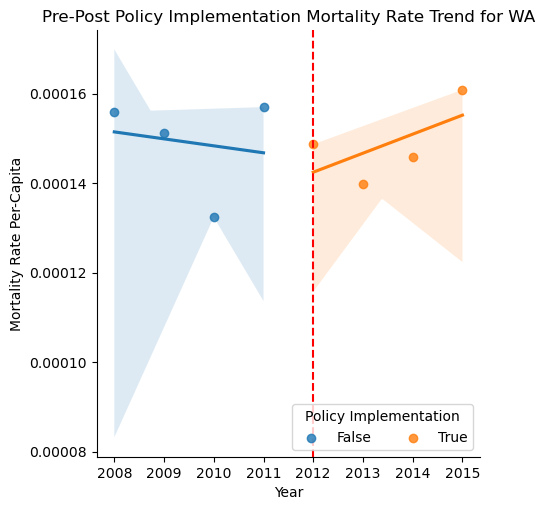

In [12]:
plot = sns.lmplot(
    data=mortality_2[mortality_2["State_Code"] == test_state],
    x="Year",
    y="Mortality_Rate",
    hue="policy_implementation",
    legend=False,
)
plot.set(title=f"Pre-Post Policy Implementation Mortality Rate Trend for {test_state}")

plt.legend(
    loc="lower right",
    # bbox_to_anchor=(0.5, -0.15),
    title="Policy Implementation",
    ncol=2,
)

ax = plot.axes[0, 0]

ax.axvline(policy_year, ls="--", color="red")
ax.set_ylabel("Mortality Rate Per-Capita")

/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(-6.359374999999991, 0.5, 'Mortality Rate Per-Capita')

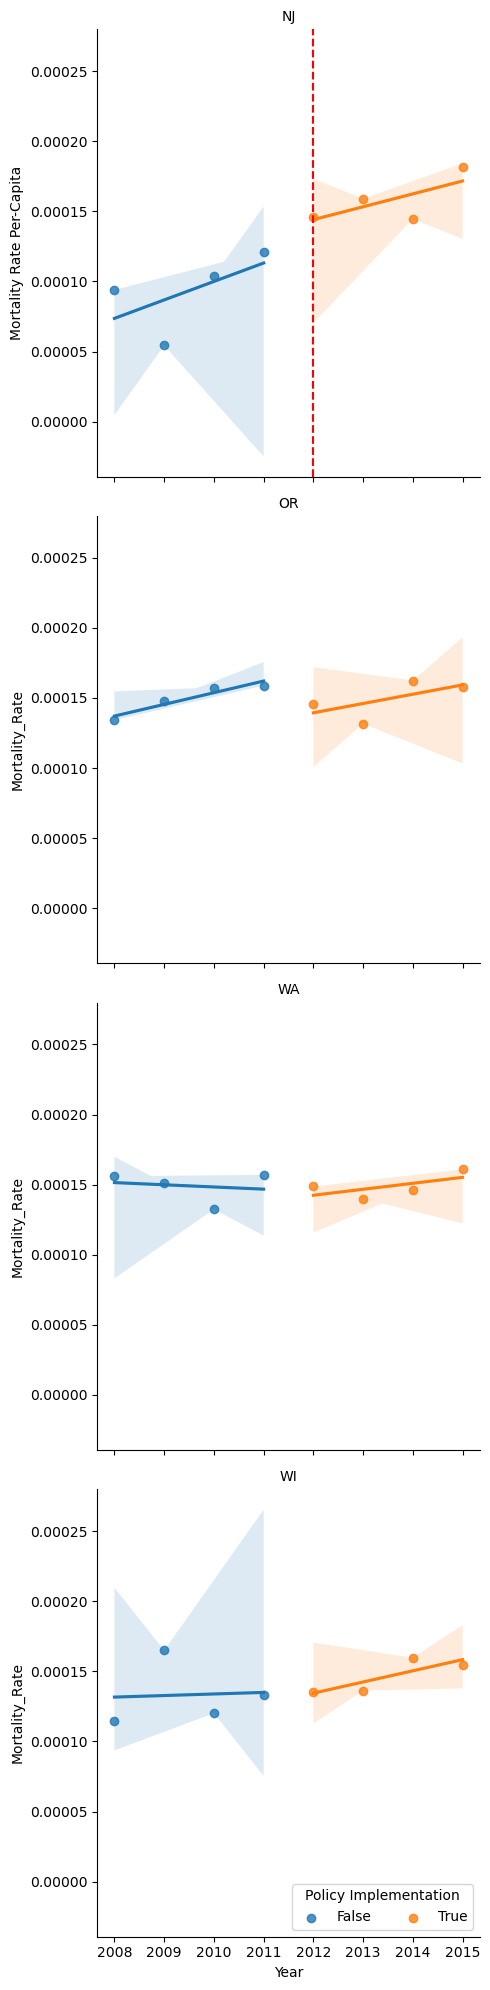

In [13]:
plot = sns.lmplot(
    data=mortality_2,
    x="Year",
    y="Mortality_Rate",
    hue="policy_implementation",
    legend=False,
    row="State_Code",
)

# Set titles for each subplot
plot = plot.set_titles("{row_name}")

plt.legend(
    loc="lower right",
    # bbox_to_anchor=(0.5, -0.15),
    title="Policy Implementation",
    ncol=2,
)

ax = plot.axes[0, 0]

ax.axvline(policy_year, ls="--", color="red")
ax.set_ylabel("Mortality Rate Per-Capita")

In [14]:
mortality_3 = (
    mortality.groupby(["State_Type", "Year", "policy_implementation"])
    .agg({"Mortality_Rate": "mean"})
    .reset_index()
)
mortality_3.sample(5)

,State_Type,Year,policy_implementation,Mortality_Rate
5,Control,2013,True,0.000144
8,Test,2008,False,0.000156
3,Control,2011,False,0.000135
9,Test,2009,False,0.000151
12,Test,2012,True,0.000149


In [15]:
mortality_3["hue_separator"] = (
    mortality_3["State_Type"]
    + " State-"
    + mortality_3["policy_implementation"].astype(str)
)

/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(-6.359374999999991, 0.5, 'Mortality Rate Per-Capita')

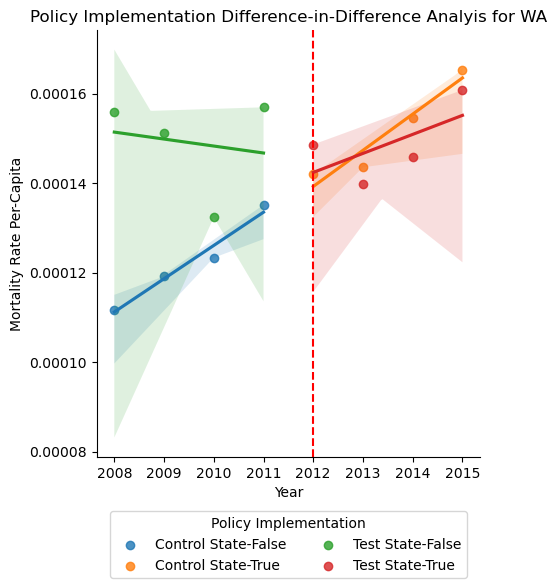

In [16]:
plot = sns.lmplot(
    data=mortality_3,
    x="Year",
    y="Mortality_Rate",
    hue="hue_separator",
    legend=False,
)
plot.set(
    title=f"Policy Implementation Difference-in-Difference Analyis for {test_state}"
)

plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    title="Policy Implementation",
    ncol=2,
)

ax = plot.axes[0, 0]

ax.axvline(policy_year, ls="--", color="red")
ax.set_ylabel("Mortality Rate Per-Capita")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


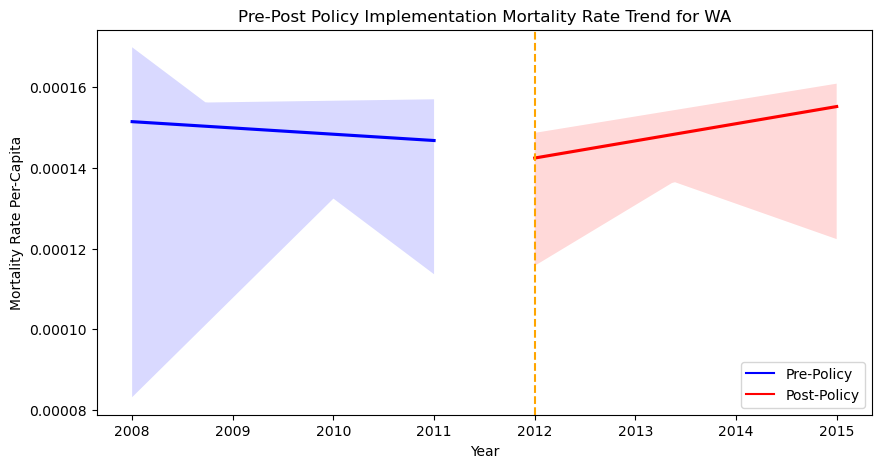

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plotting the pre-post graph
color = "red"
sns.regplot(
    data=mortality_2[
        (mortality_2["State_Code"] == test_state)
        & (mortality_2["policy_implementation"] == True)
    ],
    x="Year",
    y="Mortality_Rate",
    line_kws={"color": color},
    ax=ax,
    scatter=False,
)

# plotting the pre-post graph
color = "blue"
sns.regplot(
    data=mortality_2[
        (mortality_2["State_Code"] == test_state)
        & (mortality_2["policy_implementation"] != True)
    ],
    x="Year",
    y="Mortality_Rate",
    line_kws={"color": color},
    ax=ax,
    scatter=False,
)

# adding legends
plt.legend(
    loc="lower right",
    # bbox_to_anchor=(0.5, -0.15),
    title="Policy Implementation",
    ncol=2,
)

# addding vertical line
ax.axvline(policy_year, ls="--", color="orange")

# creating custom legend handles
blue_line = mlines.Line2D([], [], color="blue", label="Pre-Policy")
red_line = mlines.Line2D([], [], color="red", label="Post-Policy")

# adding legends
plt.legend(handles=[blue_line, red_line], loc="lower right")
plt.title(f"Pre-Post Policy Implementation Mortality Rate Trend for {test_state}")
plt.ylabel("Mortality Rate Per-Capita")

plt.savefig(f"../../Plots/{test_state}_pp_mortality.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


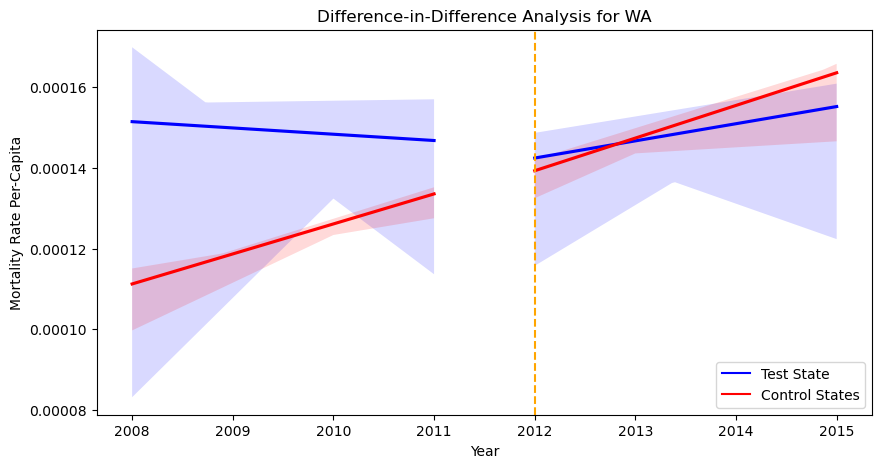

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plotting for test state
color = "blue"
sns.regplot(
    data=mortality_3[
        (mortality_3["State_Type"] == "Test")
        & (mortality_3["policy_implementation"] == True)
    ],
    x="Year",
    y="Mortality_Rate",
    line_kws={"color": color},
    ax=ax,
    scatter=False,
)

sns.regplot(
    data=mortality_3[
        (mortality_3["State_Type"] == "Test")
        & (mortality_3["policy_implementation"] != True)
    ],
    x="Year",
    y="Mortality_Rate",
    line_kws={"color": color},
    ax=ax,
    scatter=False,
)

# plotting for control states
color = "red"
sns.regplot(
    data=mortality_3[
        (mortality_3["State_Type"] == "Control")
        & (mortality_3["policy_implementation"] == True)
    ],
    x="Year",
    y="Mortality_Rate",
    line_kws={"color": color},
    ax=ax,
    scatter=False,
)

sns.regplot(
    data=mortality_3[
        (mortality_3["State_Type"] == "Control")
        & (mortality_3["policy_implementation"] != True)
    ],
    x="Year",
    y="Mortality_Rate",
    line_kws={"color": color},
    ax=ax,
    scatter=False,
)
# adding legends
plt.legend(
    loc="lower right",
    # bbox_to_anchor=(0.5, -0.15),
    title="Policy Implementation",
    ncol=2,
)

# addding vertical line
ax.axvline(policy_year, ls="--", color="orange")

# creating custom legend handles
blue_line = mlines.Line2D([], [], color="blue", label="Test State")
red_line = mlines.Line2D([], [], color="red", label="Control States")

# adding legends
plt.legend(handles=[blue_line, red_line], loc="lower right")
plt.title(f"Difference-in-Difference Analysis for {test_state}")
plt.ylabel("Mortality Rate Per-Capita")

plt.savefig(f"../../Plots/{test_state}_did_mortality.png")